先从简单的帖子开始吧：https://blog.csdn.net/liuxoxo/article/details/85218135
    关于Python的ARCH包（二）

In [ ]:
import datetime as dt
import pandas_datareader.data as web
from arch import arch_model

这里先把sp500的数据给下载下来，然后变成percent change

In [ ]:
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2014, 1, 1)
sp500 = web.DataReader('^GSPC', 'yahoo', start=start, end=end)
# 利用pct_change()把adjust colse price 变成percent change,然后把空值去掉（其实应该只有第一个值是NaN）
returns = 100 * sp500['Adj Close'].pct_change().dropna() 

In [29]:
am = arch_model(returns)
res=am.fit() #拟合
res.summary#拟合结果

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5160.989188868548
Iteration:      2,   Func. Count:     16,   Neg. LLF: 5157.537659716183
Iteration:      3,   Func. Count:     24,   Neg. LLF: 5153.785861372768
Iteration:      4,   Func. Count:     31,   Neg. LLF: 5148.008070418679
Iteration:      5,   Func. Count:     38,   Neg. LLF: 5145.433431228402
Iteration:      6,   Func. Count:     45,   Neg. LLF: 5144.580071842045
Iteration:      7,   Func. Count:     52,   Neg. LLF: 5143.795977670546
Iteration:      8,   Func. Count:     60,   Neg. LLF: 5143.634560366698
Iteration:      9,   Func. Count:     67,   Neg. LLF: 5142.965378855755
Iteration:     10,   Func. Count:     73,   Neg. LLF: 5142.940736187116
Iteration:     11,   Func. Count:     79,   Neg. LLF: 5142.938788993
Iteration:     12,   Func. Count:     85,   Neg. LLF: 5142.938783570595
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5142.93878356935
            Iterations: 12
    

<bound method ARCHModelResult.summary of                      Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -5142.94
Distribution:                  Normal   AIC:                           10293.9
Method:            Maximum Likelihood   BIC:                           10318.5
                                        No. Observations:                 3521
Date:                Tue, Mar 12 2019   Df Residuals:                     3517
Time:                        23:57:12   Df Model:                            4
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.

这里让我回顾先GARCH的模型

In [15]:
from IPython.display import Image
Image(url= "https://img-blog.csdnimg.cn/20181222213115632.png")

In [22]:
res.conf_int()

,lower,upper
mu,0.023372,0.081605
omega,0.005946,0.025261
alpha[1],0.065525,0.110150
beta[1],0.878226,0.924563


对于拟合的结果我们可以进行哪些操作：

    summary() [source] :对结果进行汇总。

    plot() ：对波动率和标准化的残差进行绘图。

    conf_int()[source] ：置信区间。

    loglikelihood ：浮点型，对数似然率的值。

    params ：时间序列类型，估计所得参数。

    param_cov ：DataFrame类型，估计参数的方差协方差。

    resid ：{ndarray, Series}：观察值数组，包括模型残差。

In [24]:
res.params

mu          0.052489
omega       0.015603
alpha[1]    0.087837
beta[1]     0.901395
Name: params, dtype: float64

In [26]:
res.forecast

<bound method ARCHModelFixedResult.forecast of                      Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -5142.94
Distribution:                  Normal   AIC:                           10293.9
Method:            Maximum Likelihood   BIC:                           10318.5
                                        No. Observations:                 3521
Date:                Tue, Mar 12 2019   Df Residuals:                     3517
Time:                        23:09:05   Df Model:                            4
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         

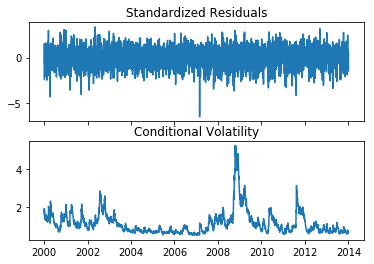

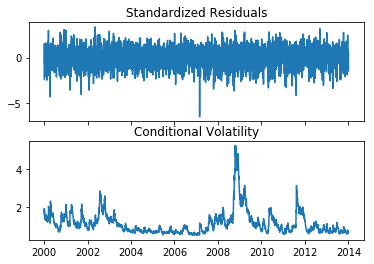

In [28]:
res.plot()

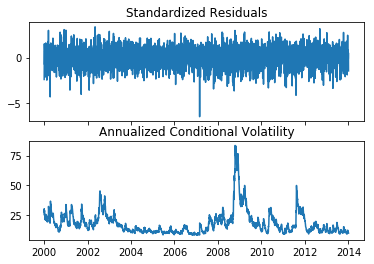

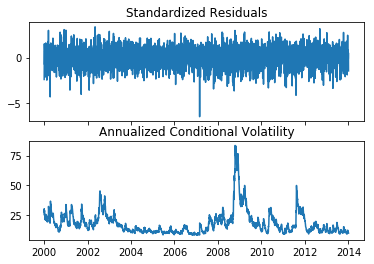

In [27]:
res.plot(annualize='D') #年化波动率图

　　【年化波动率的计算方法】

　　衡量某个指数、基金或投资组合的风险的指标有很多，年化波动率是其中比较常用的一个。年化波动率的算法也有很多种，这里我们介绍万得（Wind）的算法，这也是最常用的一种。

　　（1）年化波动率=收益率标准差*(n^0.5)。

　　其中：计算周期为日，对应n为250；计算周期为周，对应n为52；计算周期为月，对应n为12；计算周期为年，对应n为1。

In [46]:
fixed_res = am.fix([0.052489,0.015603,0.087837,0.901395])

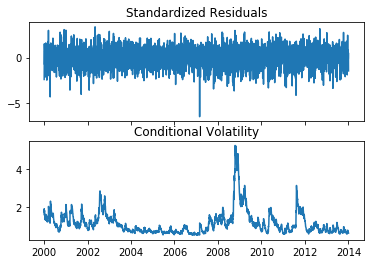

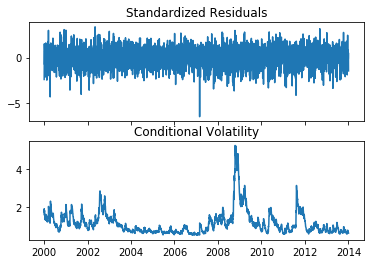

In [47]:
fixed_res.plot()

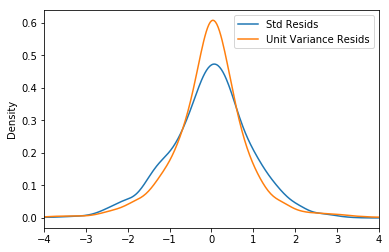

In [54]:
std_resid = res.resid / res.conditional_volatility
unit_var_resid = res.resid / res.resid.std()
df = pd.concat([std_resid, unit_var_resid],1)
df.columns = ['Std Resids', 'Unit Variance Resids']
subplot = df.plot(kind='kde', xlim=(-4,4))

In [57]:
import os
import sys

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
p = print

In [58]:
end = '2015-01-01'
start = '2007-01-01'
get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']

symbols = ['SPY','TLT','MSFT']
# raw adjusted close prices
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})
# log returns
lrets = np.log(data/data.shift(1)).dropna()

In [59]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

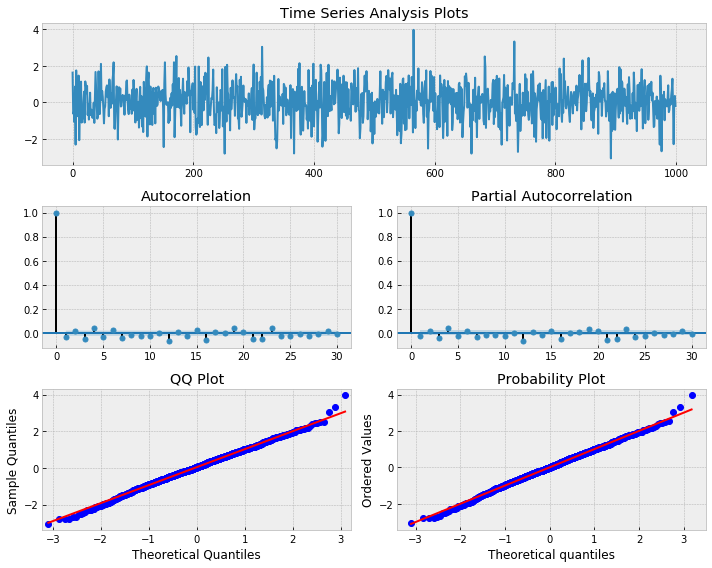

In [60]:
np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

In [61]:
res

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -5142.94
Distribution:                  Normal   AIC:                           10293.9
Method:            Maximum Likelihood   BIC:                           10318.5
                                        No. Observations:                 3521
Date:                Tue, Mar 12 2019   Df Residuals:                     3517
Time:                        23:57:12   Df Model:                            4
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0525  1.486e-02      3.533  4.105e-04 [2.